In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import math

from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.patches import Rectangle
from pyvis.network import Network

### One function for each step in the pipeline

In [2]:
def get_ocr_data(json_file):
    with open(json_file) as fp:
        data = json.loads(fp.read())
    
    nodes = []

    for b in data['Blocks']:
        if b['BlockType'] == 'LINE':
            node = {'text': b['Text'], 
                    'left': b['Geometry']['BoundingBox']['Left'], 
                    'top': b['Geometry']['BoundingBox']['Top'],
                    'right': b['Geometry']['BoundingBox']['Left'] + b['Geometry']['BoundingBox']['Width'],
                    'bottom': b['Geometry']['BoundingBox']['Top'] + b['Geometry']['BoundingBox']['Height']}

            nodes.append(node)
    
    return pd.DataFrame(nodes)

In [3]:
def open_image(filename, threshold_value = 200):
    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    threshold = 1 - (threshold / 255.)
    
    return threshold

In [4]:
def set_bounding_boxes_in_pixels(df, img):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    for i, row in df.iterrows():
         
        df.at[i, 'left']   = int(round(row['left'] * img_width))
        df.at[i, 'right']  = int(round(row['right'] * img_width))
        df.at[i, 'top']    = int(round(row['top'] * img_height))
        df.at[i, 'bottom'] = int(round(row['bottom'] * img_height))
        
    df['left']   = df['left'].astype(int)
    df['right']  = df['right'].astype(int)
    df['top']    = df['top'].astype(int)
    df['bottom'] = df['bottom'].astype(int)
    
    return df

In [5]:
def close_shape_gaps(img, dist_thershold = 30):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
    img_out = img.copy()

    for i in range(len(contours)):

        for j in range(len(contours)):

            c1 = contours[i][:,0]
            c2 = contours[j][:,0]

            dist_mat = euclidean_distances(c1, c2)

            under_threshold = np.where(dist_mat < dist_thershold)

            for c_point_i in range(len(under_threshold[0])):

                p1 = c1[under_threshold[0][c_point_i]]
                p2 = c2[under_threshold[1][c_point_i]]

                cv2.line(img_out, p1, p2, (1, 1, 1), thickness=1)
    
    return img_out

In [6]:
def close_shape_gaps2(img, dist_thershold = 30):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
    img_out = img.copy()
    
    stacked_contours_points = []

    for c in contours:
        stacked_contours_points.extend(c[:,0])

    stacked_contours_points = np.stack(stacked_contours_points, axis=0)

    dist_mat = euclidean_distances(stacked_contours_points)
    
    under_threshold = np.where(dist_mat < dist_thershold)

    for i in range(len(under_threshold[0])):

        p1 = stacked_contours_points[under_threshold[0][i]]
        p2 = stacked_contours_points[under_threshold[1][i]]

        cv2.line(img_out, p1, p2, (1, 1, 1), thickness=10)
    
    return img_out

In [7]:
def stamp_bounding_boxes_on_image(df, img):
    
    img_out = img.copy()

    for i, row in df.iterrows():

        img_out[ row['top']:row['bottom'], row['left']:row['right']] = 1
    
    return img_out

In [8]:
def get_filled_shapes(img):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_out = np.zeros_like(img)

    for i, contour in enumerate(contours):
        cv2.drawContours(img_out, [contour], 0, (1, 1, 1), thickness=cv2.FILLED)
        
    return img_out

In [9]:
def get_masks(img, max_iter=10):
    

    kernel = np.ones((3, 3), np.uint8)

    img_eroded = [img.copy()]
    contours_iter = []

    for i in range(max_iter):
        contours, tree = cv2.findContours(cv2.convertScaleAbs(img_eroded[-1]), 
                                          cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours_iter.append(contours)
        img_eroded.append(cv2.erode(img_eroded[-1], kernel, iterations = 1))
    
    min_contours = len(contours_iter[-1])
    min_contours_iteration = len(contours_iter)-1

    for i in range(len(contours_iter)-1, -1, -1):
        if len(contours_iter[i]) > min_contours:
            min_contours_iteration = i+1
            break
            
            
    nodes_mask = img_eroded[min_contours_iteration]
    
    nodes_mask_dilated = cv2.dilate(nodes_mask, kernel, iterations=min_contours_iteration+1)
    edges_mask = np.maximum((img_eroded[0] - nodes_mask_dilated), 0)


    return nodes_mask, edges_mask

In [10]:
def get_edges(edges_mask):
    
    final_edges = []

    contours, tree = cv2.findContours(cv2.convertScaleAbs(edges_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:

        countour_points = contour[:,0,:]

        x_min = np.min(countour_points[:,0])
        x_max = np.max(countour_points[:,0])
        y_min = np.min(countour_points[:,1])
        y_max = np.max(countour_points[:,1])

        candidates = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

        minimum_distances_to_candidates = np.min(euclidean_distances(candidates, countour_points), axis=1)

        final_endpoints = candidates[np.argsort(minimum_distances_to_candidates)[:4], :]
        
        
        if np.linalg.norm(final_endpoints[0] - final_endpoints[1]) * 2 < np.linalg.norm(final_endpoints[0] - final_endpoints[2]):
    
            final_endpoints = np.array([final_endpoints[0], final_endpoints[2]])

        else:
            final_endpoints = final_endpoints[0:2]

        final_edges.append(final_endpoints)


    return np.stack(final_edges)

In [12]:
def get_connections(edges, nodes_mask, dist_threshold_percentage = 2):
    
    connections = []
    
    dist_threshold_in_pixels = int((dist_threshold_percentage / 100) * nodes_mask.shape[0])
    
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for edge in edges:

        connection = [None, None]

        for i_endpoint, endpoint in enumerate(edge):

            endpoint = np.expand_dims(endpoint, axis=0)

            min_dist_to_node = 9e3
            min_dist_node_n = -1

            for i_node, node in enumerate(nodes_contours):

                node = node[:,0,:]

                min_dist = np.min(euclidean_distances(node, endpoint).squeeze())

                if min_dist < min_dist_to_node:
                    min_dist_to_node = min_dist
                    min_dist_node_n = i_node

            if min_dist_to_node < dist_threshold_in_pixels:

                connection[i_endpoint] = min_dist_node_n

        if connection[0] is not None and connection[1] is not None and connection[0] != connection[1]:
            connections.append(connection) 
    
    return pd.DataFrame(connections, columns=['node a', 'node b'])

In [13]:
def get_nodes(ocr, nodes_mask, threshold_iou = 0.8):
    
    df = ocr.copy()
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    for i, row in df.iterrows():

        area = (row['right'] - row['left']) * (row['bottom'] - row['top'])

        max_iou = 0
        max_iou_i_node = -1
        

        for i_node, contour in enumerate(nodes_contours):

            empty_img = np.zeros_like(nodes_mask)

            cv2.drawContours(empty_img, [contour], 0, (1, 1, 1), thickness=-1)

            intersection = empty_img[row['top']:row['bottom'], row['left']:row['right']].sum()

            iou = intersection / area

            if iou > max_iou:
                max_iou = iou
                max_iou_i_node = i_node

        if max_iou > threshold_iou:

            df.at[i, 'node_id'] = max_iou_i_node
    
    return df

# Real data

### 3.7.1 Inheritance_1

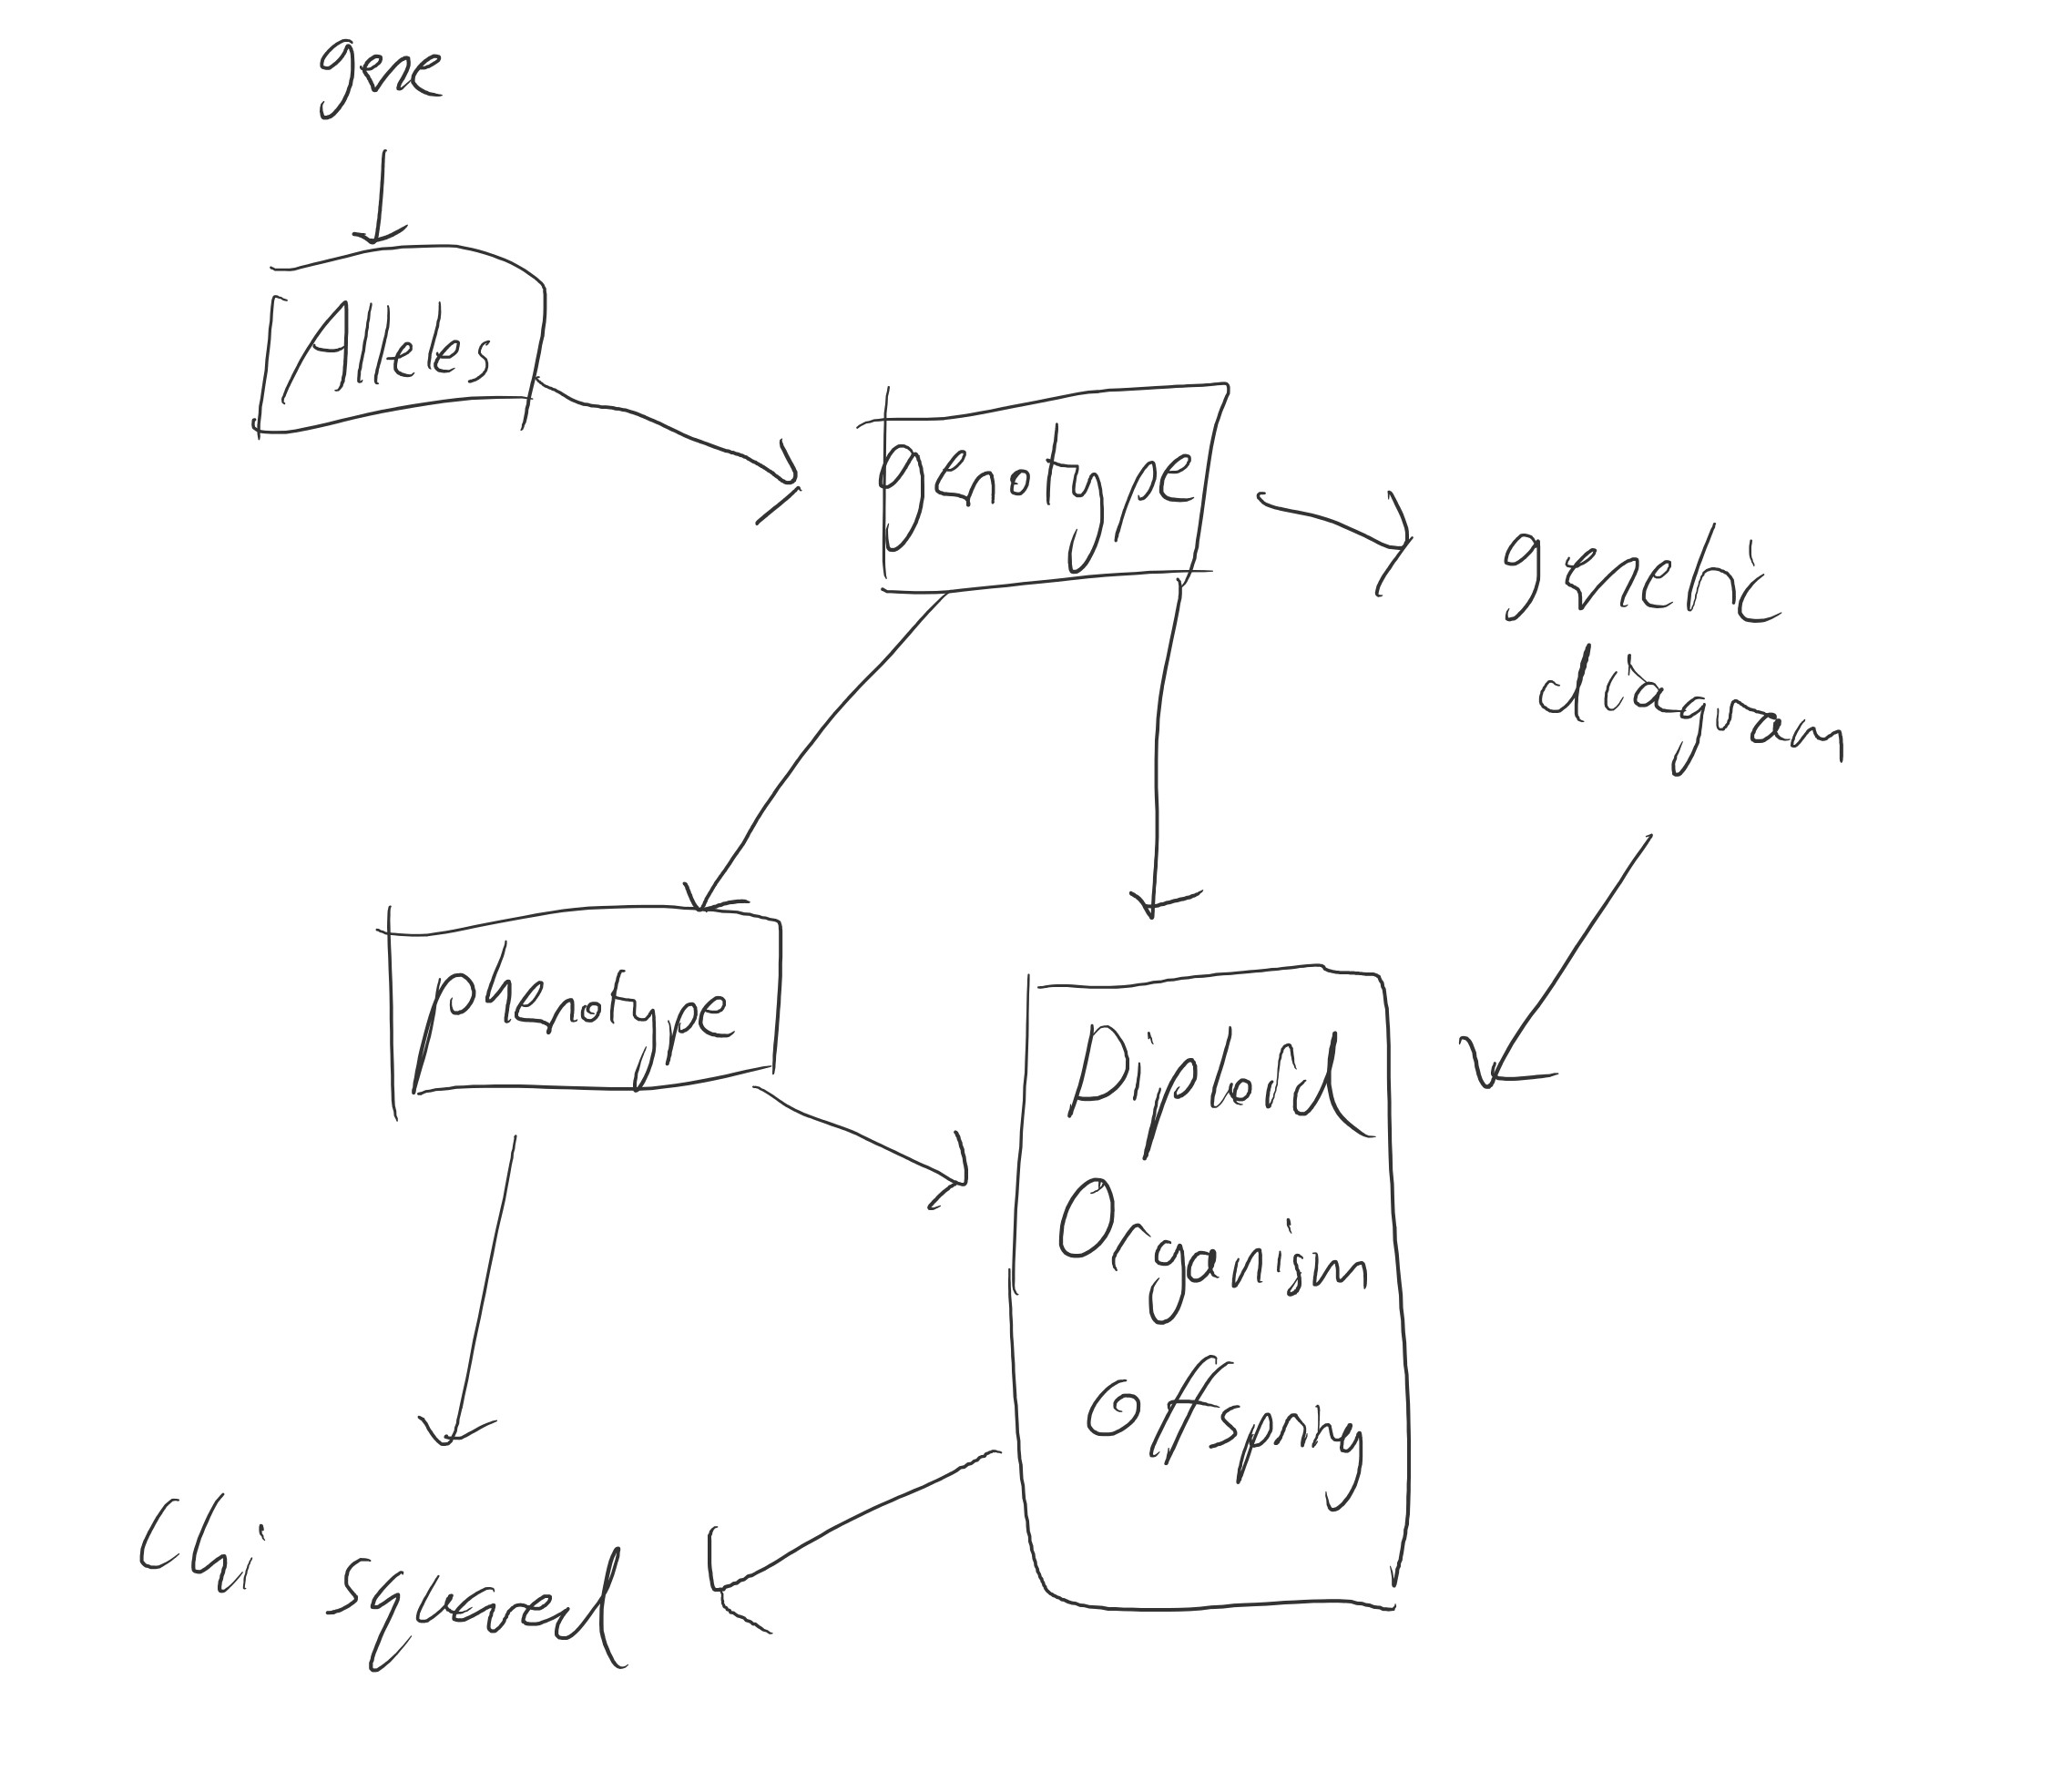

In [14]:
ocr = get_ocr_data('../textract_outputs/3.7.1 Inheritance_1/analyzeDocResponse.json')


image = []


image.append(open_image('../graphs/3.7.1 Inheritance_1.jpg', threshold_value=200))

ocr = set_bounding_boxes_in_pixels(ocr, image[-1])

image.append(close_shape_gaps2(image[-1], dist_thershold = 30))

image.append(stamp_bounding_boxes_on_image(ocr, image[-1]))

image.append(get_filled_shapes(image[-1]))

nodes_mask, edges_mask = get_masks(image[-1], max_iter = 15)


kernel = np.ones((3, 3), np.uint8)

nodes_mask = cv2.erode(nodes_mask, kernel, iterations = 10)

edges_mask = cv2.erode(edges_mask, kernel, iterations = 2)
       

image.append(nodes_mask)
image.append(edges_mask)

edges = get_edges(edges_mask)

connections = get_connections(edges, nodes_mask, dist_threshold_percentage = 30)
nodes = get_nodes(ocr, nodes_mask, threshold_iou = 0.3)

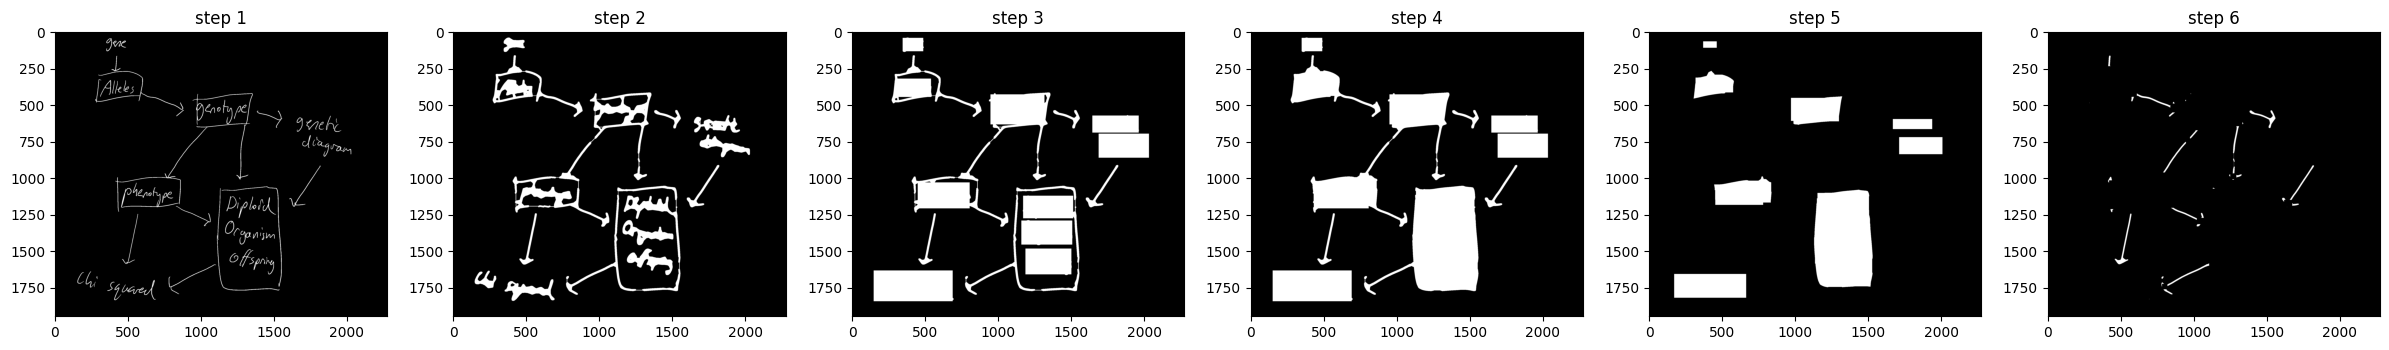

In [15]:
n_steps = len(image)

fig, ax = plt.subplots(1, n_steps, figsize=(5*n_steps, 5))

for i in range(n_steps):
    ax[i].imshow(image[i], cmap='gray')
    ax[i].set_title(f'step {i+1}')
    
plt.show()

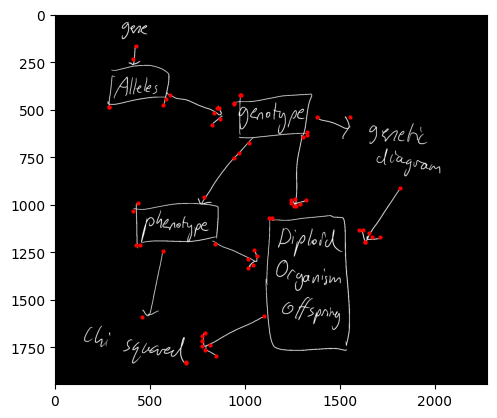

In [16]:
plt.imshow(image[0], cmap='gray')
plt.plot(edges[:, 0,0], edges[:,0,1],'ro', markersize=2)
plt.plot(edges[:, 1,0], edges[:,1,1],'ro', markersize=2)
plt.show()

In [17]:
nodes['text'] = nodes.groupby('node_id')['text'].transform(lambda x: '\n'.join(x))
nodes.drop_duplicates('text', inplace=True)

nodes

,text,left,top,right,bottom,node_id
0,gene,346,40,487,132,7.0
1,Alleles,294,319,540,445,6.0
2,genotype,946,427,1315,633,5.0
3,genetic,1642,572,1959,689,4.0
4,diagram,1685,696,2029,861,3.0
5,phenolype,449,1030,804,1208,2.0
6,Diploid\nOrganism\noffspring,1169,1121,1511,1276,1.0
9,Chi squared,148,1633,688,1844,0.0


In [18]:
connections

,node a,node b
0,1,0
1,2,0
2,2,1
3,1,3
4,5,2
5,5,1
6,5,4
7,6,5
8,6,7


In [19]:
net = Network(notebook=True)

colors=['lightgreen', 'gray', 'darkblue', 'blue', 'red', 'black']

In [20]:
net.add_nodes(nodes.node_id.astype(int).tolist(),              
                title=nodes.text.tolist(),
                x=[n/10 for n in nodes.left.astype(int).tolist()],
                y=[n/10 for n in nodes.top.astype(int).tolist()],
                label=nodes.text.tolist(),
                color=np.random.choice(colors, size=len(nodes), replace=True).tolist())

In [21]:
for i, row in connections.iterrows():
    net.add_edge(int(row['node a']), int(row['node b']))

net.add_edge(1, 2,weight=.87, color='red')
net.show('mygraph.html')

mygraph.html


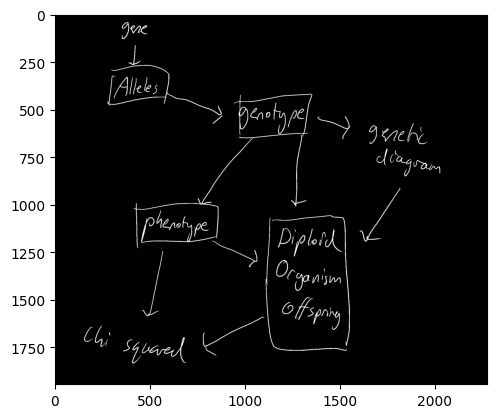

In [22]:
plt.imshow(image[0], cmap='gray')
plt.show()